# **Thermischer Komfort**
___

## Importe

In [13]:
### Jupyter Einstellungen
%load_ext autoreload
%autoreload 2

### Python Pakete
from zoneinfo import ZoneInfo
tz = ZoneInfo('Europe/Berlin')

import locale
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import math
import numpy as np
import pandas as pd
from pandas import IndexSlice as IDX

import src.toolbox as tb
import src.style as style
from src.style import BUID, ROOMS, APPS
from src.preprocessing import getDB, calculatePMVPPD, getAdaptiveComfort, removeUnoccupied, estimateOperativeTemperature, getData

### Datenbank Import
try:
    from src.preprocessing import DB, AMB
except ImportError:
    getDB()
    from src.preprocessing import DB, AMB
DB.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


bui                          LB                                           \
app                           N                                            
room                          B                                            
value                     HK_IO  Rh Rh_amb T_amb T_amb_g24 Tair Thk Tset   
Datetime                                                                   
2021-02-08 11:00:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:01:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:02:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:03:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:04:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   

bui                                      ...  MW                              \
app                                      ...   S                               
room                                  K  ...  WZ                               
value                     g_abs Fenster  ...  Rh Rh_amb T_amb T_amb_g24 Tair   
Datetime                                 ...                                   
2021-02-08 11:00:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:01:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:02:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:03:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:04:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   

bui                                               
app                                               
room                                              
value                     Thk Top Tset Tsk g_abs  
Datetime                                          
2021-02-08 11:00:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:01:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:02:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:03:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:04:00+01:00 NaN NaN  NaN NaN   NaN  

[5 rows x 408 columns]

# **PMV + PPD**

__To-Dos__

- Abgleich der Eingangsparameter mit der DIN 16798 und der SIA 2024-2021

Berechne PMV...

In [14]:
ThermalComfort, pmv_params = calculatePMVPPD(update=False)

Öffne PMV-PPD Datenbank...


In [15]:
df = ThermalComfort.loc[:, IDX[:,['N', 'S'],:,:]]
PMV = []
for (bui, app, room), group in df.groupby(level=[0,1,2], axis=1):
    group = group.stack([0,1,2]).reset_index()
    group = group.assign(comf = group['pmv'].abs().lt(0.5))
    PMV.append(group.groupby((group.comf != group.comf.shift()).cumsum()).agg({'bui':'first', 'app':'first', 'room': 'first', 'Datetime':['first', 'last', tb.utils.aggMINMAX], 'pmv': ['mean'], 'comf':['mean']}).set_axis(['bui', 'app', 'room', 'start','end', 'duration', 'pmv_mean', 'comfortable'], axis=1).where(lambda df: df.comfortable==0).dropna(how='all'))
PMV = pd.concat(PMV).reset_index(drop=True)
PMV.groupby(['bui', 'app', 'room'])['duration'].agg(['sum', 'mean'])

sum                      mean
bui app room                                            
LB  N   SZ   153 days 17:00:00 0 days 15:54:03.103448275
        WZ    76 days 09:00:00    1 days 04:38:26.250000
    S   SZ    79 days 01:00:00 0 days 05:08:27.317073170
        WZ    28 days 02:00:00           0 days 07:01:15
MH  N   SZ   257 days 13:00:00 1 days 02:59:28.558951965
        WZ   218 days 19:00:00 1 days 00:46:07.924528301
    S   SZ   227 days 09:00:00 1 days 01:01:55.596330275
        WZ    79 days 11:00:00 0 days 06:10:17.475728155
MW  N   SZ    75 days 02:00:00 0 days 13:58:08.372093023
        WZ    80 days 07:00:00 0 days 19:39:47.755102040
    S   SZ   135 days 03:00:00           0 days 17:37:30
        WZ    76 days 10:00:00 0 days 11:40:53.503184713

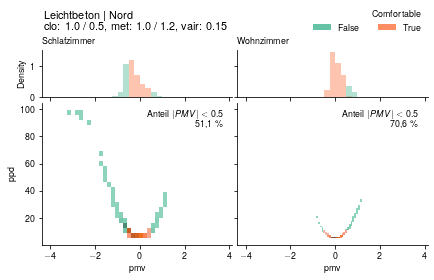

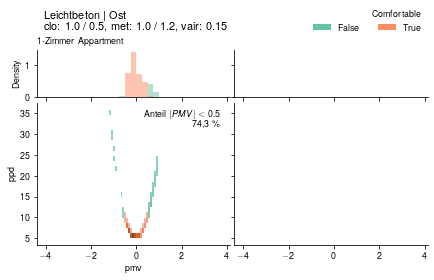

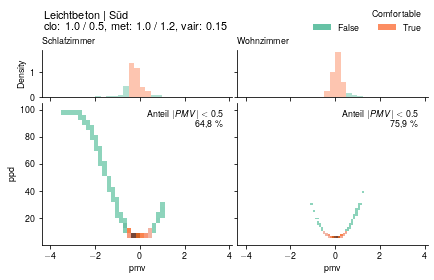

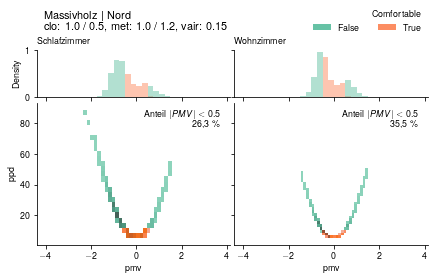

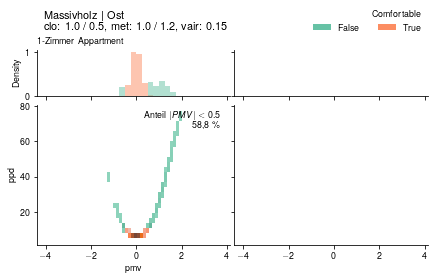

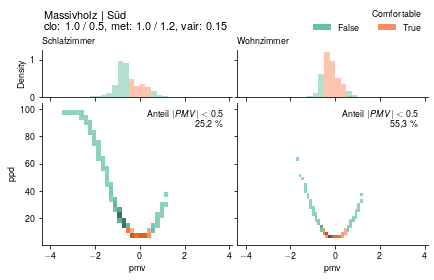

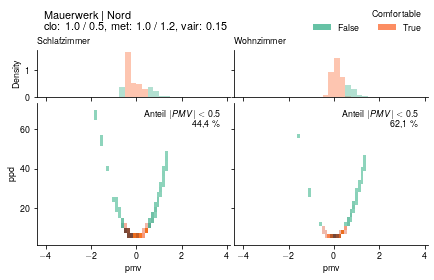

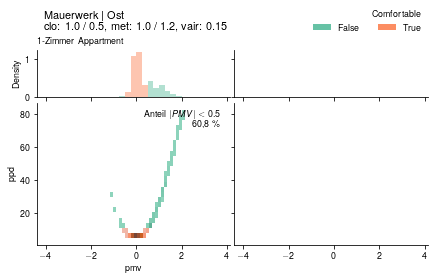

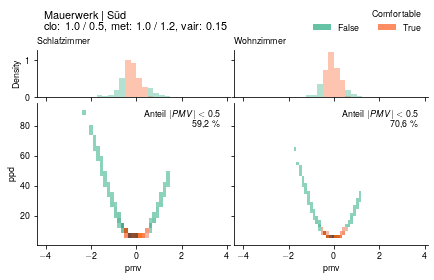

In [16]:
for (bui, app), _group in ThermalComfort.groupby(level=[0,1], axis=1):
    fig, axs = plt.subplots(2,2,gridspec_kw={'height_ratios':[1,3]}, sharex=True, sharey='row')
    for r, (room, group) in enumerate(_group.groupby(level=2,axis=1)):
        ax1 = sns.histplot(x=group[bui][app][room]['pmv'], y=group[bui][app][room]['ppd'], hue= (group[bui][app][room]['pmv'].abs() <= 0.5), ax=axs[1][r], palette='Set2', legend=False, ec='None', bins=25)
        ax0 = sns.histplot(data=ThermalComfort[bui][app][room], x='pmv', hue=(ThermalComfort[bui][app][room]['pmv'].abs() <= 0.5), ax=axs[0][r], bins=np.arange(-4,4,.25), stat='density',common_norm=True, common_bins=True, palette='Set2', legend=False, edgecolor='None')
        ax0.set_title(f'{ROOMS[room]}')
        ax1.text(.95,.95, s=f'Anteil $|PMV| < 0.5$\n{group[bui][app][room]["pmv"].abs().lt(0.5).mean()*100:.3n} \\%', ha='right', va='top', transform=ax1.transAxes)
    fig.suptitle(f"{BUID[bui]} | {APPS[app]}\nclo: {pmv_params['clo_winter']} / {pmv_params['clo_summer']}, met: {pmv_params['met_SZ']} / {pmv_params['met_rest']}, vair: {pmv_params['vair']}", x=0.09, y=1.01, ha='left', va='top')
    leg = fig.legend(handles=[mpl.patches.Patch(facecolor=plt.cm.Set2(0), label=False), mpl.patches.Patch(facecolor=plt.cm.Set2(1), label=True)], title='Comfortable', ncol=2, bbox_to_anchor=(1,1.04), loc='upper right')
    leg._legend_box.align = "right"
    fig.tight_layout(pad=0.1)

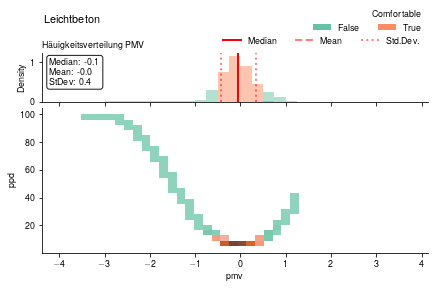

In [17]:
for bui, group in ThermalComfort.stack(level=[1,2]).groupby(level=0, axis=1):
    fig, (ax1, ax2) = plt.subplots(2,1,gridspec_kw={'height_ratios':[1,3]}, sharex=True, sharey='row')
    ax1.set_title('Häuigkeitsverteilung PMV')
    sns.histplot(x=group[bui]['pmv'], y=group[bui]['ppd'], hue= (group[bui]['pmv'].abs() <= 0.5),ax=ax2, palette='Set2', legend=False, edgecolor='None', bins=25)
    sns.histplot(data=group[bui], x='pmv', hue=(group[bui]['pmv'].abs() <= 0.5),ax=ax1, bins=np.arange(-4,4,.25), stat='density',common_norm=True, common_bins=True, palette='Set2', legend=False, edgecolor='None')
    ax1.axvline(group[bui]['pmv'].median(), c='r', linewidth=2, label='Median')
    ax1.axvline(group[bui]['pmv'].mean(), c='r', linewidth=2, alpha=0.5,
                linestyle='dashed', label='Mean')
    ax1.axvline(group[bui]['pmv'].mean() - group[bui]['pmv'].std(), c='r', linewidth=2,
                alpha=0.5, linestyle='dotted', label='Std.Dev.')
    ax1.axvline(group[bui]['pmv'].mean() + group[bui]['pmv'].std(), c='r',
                linewidth=2, alpha=0.5, linestyle='dotted')
    ax1.legend(ncol=3, bbox_to_anchor=(1, 1),
                loc='lower right', frameon=False)
    ax1.text(0.02, 0.9, f"Median: {group[bui]['pmv'].median():.1f}\nMean: {group[bui]['pmv'].mean():.1f}\nStDev: {group[bui]['pmv'].std():.1f}",
                transform=ax1.transAxes, bbox=style.bbox_props, va='top', ha='left')
    
    fig.suptitle(f'{BUID[bui]}', x=0.09, y=1.025, ha='left')
    leg = fig.legend(handles=[mpl.patches.Patch(facecolor=plt.cm.Set2(0), label=False), mpl.patches.Patch(facecolor=plt.cm.Set2(1), label=True)], title='Comfortable', ncol=2, bbox_to_anchor=(1,1.07), loc='upper right')
    leg._legend_box.align = "right"
    fig.tight_layout(pad=0.1)

# Adaptive Comfort
___

In [27]:
def getOccupied(df):
    if hasattr(df.index, 'freq'):
        _freq_ = df.index.freqstr
        _anw = DB.loc[:, IDX[:,:,'WE', 'Anwesenheit']].resample(_freq_).quantile(.5, interpolation='nearest').droplevel([2,3], axis=1)
        for col, group in df.groupby(level=['bui', 'app'], axis=1):
            df[col] = df.loc[:,col].where(_anw[col]>0)
    return df
    
def style_crit(v, props=''):
    return props if v > 0.02 else None

def getComfortGraphs(bui, app, occupied =True, which='all', export=False, **kwargs):
    global TOP
    if 'TOP' not in globals():
        TOP = estimateOperativeTemperature()

    Tamb = getData(bui=bui, app=app, value='T_amb', occupied=occupied).droplevel(3,axis=1).groupby(level=1, axis=1).mean()        
    Tair = getData(bui=bui, app=app, value='Tair', occupied=occupied).droplevel(3,axis=1).groupby(level=1, axis=1).mean()
    rH = getData(bui=bui, app=app, value='Rh', occupied=occupied).droplevel(3,axis=1).groupby(level=1, axis=1).mean()
    if occupied:
        Top = getOccupied(TOP.loc[:, IDX[bui,app,:,:]].droplevel(3,axis=1)).groupby(level=1, axis=1).median()
        _title = f'{BUID[bui]} | {APPS[app]} (Nutzungszeitraum)'
    else:
        Top = TOP.loc[:, IDX[bui,app,:,:]].droplevel(3,axis=1).groupby(level=1, axis=1).median()
        _title = f'{BUID[bui]} | {APPS[app]}'

    kws = dict(kind='hist', title=_title)
    kws.update(**kwargs)

    if which in ['all', 'NA']:
        tb.comf.adaptive_comfort_NA(Tamb, Top, **kws)
        if export:
            style.toTex('appendix', f'Beispiel_NA')
    if which in ['all', 'EN']:
        tb.comf.adaptive_comfort_EN(Tamb, Top, **kws)
        if export:
            style.toTex('appendix', f'Beispiel_EN')
    if which in ['all', 'HX']:
        tb.comf.hxdiagramm(Tair, rH, **kws)
        if export:
            style.toTex('appendix', f'Beispiel_HX')

Timestep is <Minute>. Resampling to Hour...


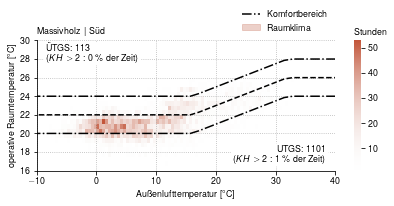

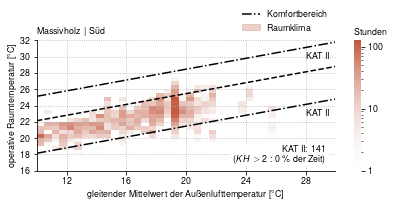

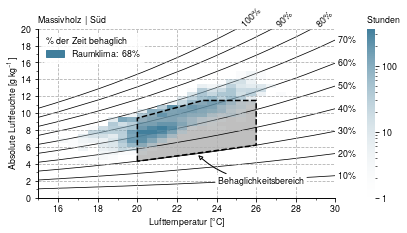

In [28]:
getComfortGraphs('MH', 'S', **style.size(0.5), occupied=False) 